<a href="https://colab.research.google.com/github/yhussain1/MachineLearning/blob/main/TextGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Library imports
import tensorflow as tf
import numpy as np
import os
import time

In [49]:
# download Shakespeare dataset
from google.colab import files
upload_file = files.upload()
!unzip 'hp.zip'

Saving hp.zip to hp.zip
Archive:  hp.zip
  inflating: Book1.txt               
  inflating: Book2.txt               
  inflating: Book3.txt               
  inflating: Book4.txt               
  inflating: Book5.txt               
  inflating: Book6.txt               
  inflating: Book7.txt               
  inflating: characters_list.csv     


In [63]:
filenames = ['Book1.txt', 'Book2.txt', 'Book3.txt', 'Book4.txt',
             'Book5.txt', 'Book6.txt', 'Book7.txt']

import shutil

with open('file.txt','wb') as wfd:
    for f in filenames:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)

In [64]:
path_to_file = 'file.txt'

In [65]:
#read and decode for python compatibility
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
#number of characters in text
print(f'Length of text: {len(text)} characters')

Length of text: 6765174 characters


In [66]:
#1st 250 chars in text
print(text[:250])

/ 




THE BOY WHO LIVED 

Mr. and Mrs. Dursley, of number four, Privet Drive, 
were proud to say that they were perfectly normal, 
thank you very much. They were the last people you’d 
expect to be involved in anything strange or 
mysterious, becaus


In [67]:
#total unique chars in text
vocab = sorted(set(text))
print(f' {len(vocab)} unique characters')

 92 unique characters


In [68]:
#process text with vectorisation
#split text to tokens
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [69]:
#will convert each character to a numeric id
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [70]:
# example string tokens converted to char ids
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[57, 58, 59, 60, 61, 62, 63], [80, 81, 82]]>

In [71]:
#will invert the vectors back into readable text
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(),
                                              invert=True, mask_token=None)

In [72]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [73]:
#join chars back into strings
tf.strings.reduce_join(chars, axis=1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [74]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [75]:
#tokenize
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(6765174,), dtype=int64, numpy=array([14,  2,  1, ...,  1,  1,  1])>

In [76]:
#convert text vectors to char indices
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [77]:
for ids in ids_dataset.take(11):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

/
 










T
H
E
 


In [78]:
seq_length = 100

In [79]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'/' b' ' b'\n' b'\n' b'\n' b'\n' b'\n' b'T' b'H' b'E' b' ' b'B' b'O'
 b'Y' b' ' b'W' b'H' b'O' b' ' b'L' b'I' b'V' b'E' b'D' b' ' b'\n' b'\n'
 b'M' b'r' b'.' b' ' b'a' b'n' b'd' b' ' b'M' b'r' b's' b'.' b' ' b'D'
 b'u' b'r' b's' b'l' b'e' b'y' b',' b' ' b'o' b'f' b' ' b'n' b'u' b'm'
 b'b' b'e' b'r' b' ' b'f' b'o' b'u' b'r' b',' b' ' b'P' b'r' b'i' b'v'
 b'e' b't' b' ' b'D' b'r' b'i' b'v' b'e' b',' b' ' b'\n' b'w' b'e' b'r'
 b'e' b' ' b'p' b'r' b'o' b'u' b'd' b' ' b't' b'o' b' ' b's' b'a' b'y'
 b' ' b't' b'h' b'a'], shape=(101,), dtype=string)


In [80]:
#convert to human readable sentence
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'/ \n\n\n\n\nTHE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say tha'
b't they were perfectly normal, \nthank you very much. They were the last people you\xe2\x80\x99d \nexpect to be inv'
b'olved in anything strange or \nmysterious, because they just didn\xe2\x80\x99t hold with such \nnonsense. \n\nMr. Du'
b'rsley was the director of a firm called \nGrunnings, which made drills. He was a big, beefy \nman with '
b'hardly any neck, although he did have a \nvery large mustache. Mrs. Dursley was thin and \nblonde and h'


In [81]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [82]:
split_input_target(list('Tensorflow'))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [83]:
dataset = sequences.map(split_input_target)

In [84]:
for input_example, target_example in dataset.take(1):
  print('Input :', text_from_ids(input_example).numpy())
  print('Target :', text_from_ids(target_example).numpy())

Input : b'/ \n\n\n\n\nTHE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say th'
Target : b' \n\n\n\n\nTHE BOY WHO LIVED \n\nMr. and Mrs. Dursley, of number four, Privet Drive, \nwere proud to say tha'


In [85]:
#shuffle and pack data into batches
batch = 64
buffer = 10000

dataset = (
    dataset.shuffle(buffer).batch(batch, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
)

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Building the Model

In [86]:
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 356
rnn_units = 1024

In [87]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x


In [88]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

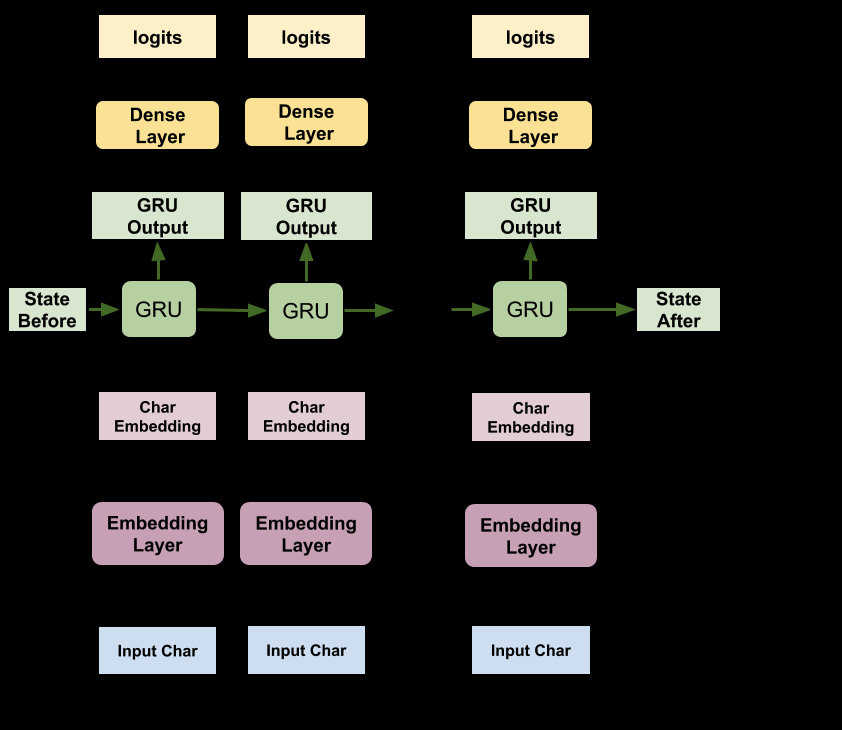

In [89]:
for input_example_batch, target_example_batch in dataset.take(1): # shape output
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 93) # (batch_size, sequence_length, vocab_size)


In [90]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  33108     
                                                                 
 gru_1 (GRU)                 multiple                  4245504   
                                                                 
 dense_1 (Dense)             multiple                  95325     
                                                                 
Total params: 4,373,937
Trainable params: 4,373,937
Non-trainable params: 0
_________________________________________________________________


In [91]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()


In [92]:
sampled_indices

array([ 3, 89, 85, 89, 53, 34, 21, 87, 86, 86, 50,  4, 30, 40, 33, 33, 53,
       92, 62, 13, 25,  1, 53, 19, 33, 32, 30, 52, 71, 43, 75,  2, 69, 34,
       83, 79,  9, 57, 78, 70, 82, 64, 63, 92,  5, 44, 31, 46,  4, 59, 90,
       20, 45, 60,  5, 76, 55, 82, 74, 27, 87,  2, 14, 19, 26, 92,  5, 52,
       23, 15, 19, 71, 86,  9, 37, 30,  9,  9,  7, 72,  3, 25, 53, 68,  4,
       91, 83, 58, 17, 26, 47, 30,  8, 55, 65, 49, 60, 55, 16, 67])

In [93]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ou?\xe2\x80\x9d \n\nAs he had expected, Mrs. Dursley looked shocked and \nangry. After all, they normally pretende'

Next Char Predictions:
 b'!\xe2\x80\x9d\xe2\x80\x94\xe2\x80\x9dYF6\xe2\x80\x99\xe2\x80\x98\xe2\x80\x98V"BLEEY\xe2\x96\xa1f.:\nY4EDBXoOs mF|w)avnzhg\xe2\x96\xa1%PCR"c\xe2\x80\xa25Qd%t\\zr>\xe2\x80\x99 /4;\xe2\x96\xa1%X804o\xe2\x80\x98)IB))\'p!:Yl"\xe2\x96\xa0|b2;SB(\\iUd\\1k'


In [94]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [95]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 93)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.534108, shape=(), dtype=float32)


In [96]:
tf.exp(example_batch_mean_loss).numpy()

93.14041

In [97]:
model.compile(optimizer='adam', loss=loss)


In [98]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [99]:
epochs = 30

In [100]:
history = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

Epoch 1/30
1046/1046 [==============================] - 67s 62ms/step - loss: 1.6664
Epoch 2/30
1046/1046 [==============================] - 67s 63ms/step - loss: 1.1619
Epoch 3/30
1046/1046 [==============================] - 65s 61ms/step - loss: 1.0824
Epoch 4/30
1046/1046 [==============================] - 65s 61ms/step - loss: 1.0408
Epoch 5/30
1046/1046 [==============================] - 67s 63ms/step - loss: 1.0114
Epoch 6/30
1046/1046 [==============================] - 66s 62ms/step - loss: 0.9892
Epoch 7/30
1046/1046 [==============================] - 65s 61ms/step - loss: 0.9710
Epoch 8/30
1046/1046 [==============================] - 66s 62ms/step - loss: 0.9559
Epoch 9/30
1046/1046 [==============================] - 65s 61ms/step - loss: 0.9441
Epoch 10/30
1046/1046 [==============================] - 65s 61ms/step - loss: 0.9350
Epoch 11/30
1046/1046 [==============================] - 66s 62ms/step - loss: 0.9278
Epoch 12/30
1046/1046 [==============================] - 67s 63

In [101]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [107]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature=0.6)

In [108]:
start = time.time()
states = None
next_char = tf.constant(['Harry:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Harry: 




Page | 299 Harry Pot the 
and 
they were cally and her wand word unnot 
whit had the coulder the more k was cloolled drean 

thight the clowr and the 
clows appered?” 


“A hall was sured him on other tim. They could over he with that he was suight for in day and 
wholed and that he where’s was drick 

“Huck it whem — ” said Hermione in. 

“Mold Harry how whed of the Porewing to had 
they doore surey looking the stanked in of the flacest of 

They what his 

Harry. 

“I say and the Deathly Harry for on the was what wisher looked saw, 

Harry to the be 
hadeas that he what had to whe the chan his blooke the was me,” said Ron’ soure that the mat intille youran’ whicher his as 
and a 

“Prof he saw 
the selt don’t 
and dreak of the 
on whathurl. Herm me could you backed whor a down 
Paget| 43 

“The mad the was meally of the done the Hadled to her 


Page | 397 Harry Potter and the Dareffry at of the cont had bellowe see light with the was was beed 
out ifrecting thee wothit, 

In [109]:
start = time.time()
states = None
next_char = tf.constant(['Harry:',  'Harry:', 'Harry:', 'Harry:', 'Harry:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b'Harry: \n\n\n\n\n\n\n\n\nPage | 46 and the Deathly Hallows - J.K. Rowling \n\n\n\n\n\n\xe2\x80\x9cThe\xe2\x80\x99r was he was \n\n\xe2\x80\x9cWhink a campere the re melles, and frammingersso bled ove him. \n\n\xe2\x80\x9cWhand been a le we cudden think on the searne that the \nthat they not, and they wat everying the \ndore and the Dering AmTor of the mare \nthe selt the frombechingo \nreake hud the mepor them with trachet did ints and look dince booke \nhin \nthe dea had not the wowly the could more \nout it a mored \n\n\xe2\x80\x9cWhat\xe2\x80\x99s \nhe dow \nbut soulled he stim; \nMassly \xe2\x80\x99s got with stand. \n\n\xe2\x80\x9cAry I\xe2\x80\x99ven to knows fee so \nshink thear any the \nseatly were in the see the we was cere f were thing the be could \nbroiwor dow, and \nGoom her him sect come book \nand Merowe the Selew \nwas bute cantille a to finger, he was whough the be wand said \nHarry was \nstiff at perse of \nand her what of the Miging \n\n\xe2\x80\x9cYou

In [110]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [111]:
states = None
next_char = tf.constant(['Harry:'])
result = [next_char]

for n in range(500):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

Harry: 





Ho were wat did Harry. “What 
yound the pesped better not dispold 
Mast and Snerive of the ere backed and the 
looked the tor 


Prienester and the Dad Deathly Hallows - J.K. Rowling 

“I cold did 
feen the stoo her — whatt on the was word knight back And and with the entle, but 
they shelpet this could and 
Lowe of himent if he hat’s 

Harry don’t 
are Snling 



Looking 



Pobe the right. 

“All out sivery, whind to Dumblooking and 
ale the red 
the wor and the 
with her with chace wou
